In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
df1 = pd.read_csv('../data/2020/20_agg_data.csv')
df2 = pd.read_csv('../data/2019/19_agg_data.csv')
df3 = pd.read_csv('../data/2018/18_agg_data.csv')

In [4]:
comb_df = pd.concat([df1, df3])
comb_df.describe()

,Time,Max Concentration,Last Pit,Air Temp,Track Temp,Humidity,Pressure,Wind Speed,Yellow
count,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000
mean,43200.888116,6.175951,49.023284,62.287387,63.636293,69.977159,30.140485,1.339270,0.004638
std,24949.933139,2.613091,13.380228,8.573374,10.207679,15.521106,0.073102,1.528376,0.067946
min,20.000000,0.533049,0.333333,46.400000,32.000000,34.000000,30.013212,0.000000,0.000000
25%,21600.000000,4.251701,43.246117,55.099940,55.999940,62.000000,30.086152,0.000000,0.000000
50%,43200.000000,5.709946,49.798533,64.900040,64.000040,73.000000,30.122179,0.600000,0.000000
75%,64780.000000,7.422930,53.512617,67.699940,69.000080,82.000000,30.197185,1.900000,0.000000
max,86440.000000,27.407742,144.666667,77.000000,98.000060,91.000000,30.269238,9.800000,1.000000


In [5]:
neg, pos = np.bincount(comb_df['Yellow'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 8625
    Positive: 40 (0.46% of total)



In [6]:
cleaned_df = comb_df.copy()
cleaned_df.pop('Time')

eps = 0.001 
cleaned_df['Last Pit'] = np.log(cleaned_df['Last Pit']+eps)

In [7]:
cleaned_df.describe()

,Max Concentration,Last Pit,Air Temp,Track Temp,Humidity,Pressure,Wind Speed,Yellow
count,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000
mean,6.175951,3.848837,62.287387,63.636293,69.977159,30.140485,1.339270,0.004638
std,2.613091,0.338140,8.573374,10.207679,15.521106,0.073102,1.528376,0.067946
min,0.533049,-1.095617,46.400000,32.000000,34.000000,30.013212,0.000000,0.000000
25%,4.251701,3.766931,55.099940,55.999940,62.000000,30.086152,0.000000,0.000000
50%,5.709946,3.908006,64.900040,64.000040,73.000000,30.122179,0.600000,0.000000
75%,7.422930,3.979936,67.699940,69.000080,82.000000,30.197185,1.900000,0.000000
max,27.407742,4.974439,77.000000,98.000060,91.000000,30.269238,9.800000,1.000000


In [8]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, val_df = train_test_split(cleaned_df, test_size=0.2)
test_df = df2
test_df.pop('Time')

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Yellow'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Yellow'))
test_labels = np.array(test_df.pop('Yellow'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (6900,)
Validation labels shape: (1725,)
Test labels shape: (3188,)
Training features shape: (6900, 7)
Validation features shape: (1725, 7)
Test features shape: (3188, 7)


C:\Users\dithu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\dithu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


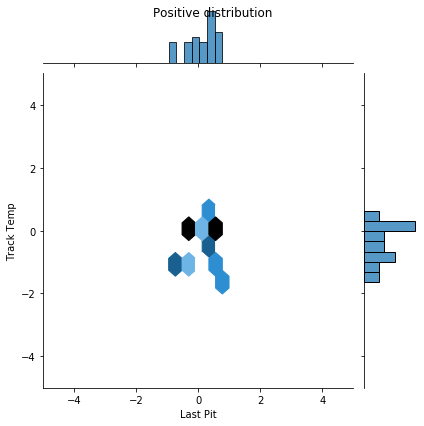

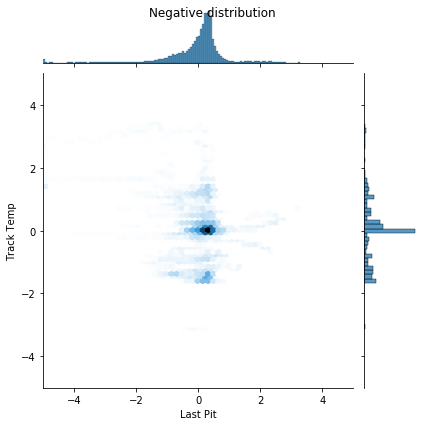

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['Last Pit'], pos_df['Track Temp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Last Pit'], neg_df['Track Temp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None, dropout=0.5):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(dropout),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                128       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.predict(train_features[:10])

array([[0.8897715 ],
       [0.8251958 ],
       [0.9257693 ],
       [0.77124554],
       [0.83458763],
       [0.72430104],
       [0.8900319 ],
       [0.9336822 ],
       [0.834376  ],
       [0.9162545 ]], dtype=float32)

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.9568


In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.36889232])

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.004444  ],
       [0.0066582 ],
       [0.00253844],
       [0.00620538],
       [0.00747421],
       [0.00533336],
       [0.00594661],
       [0.01214981],
       [0.00381479],
       [0.0091126 ]], dtype=float32)

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0309


In [19]:
initial_weights = '../data/inital_weights'
model.save_weights(initial_weights)

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

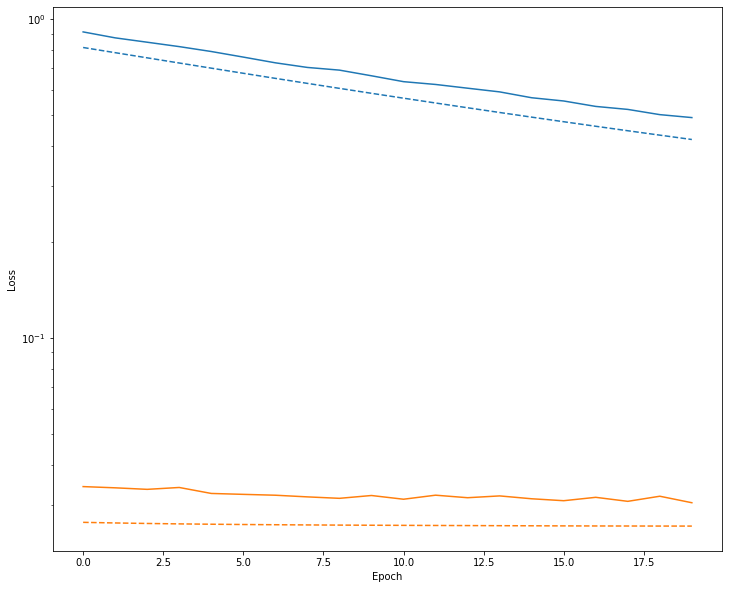

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

BASELINE

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


In [25]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.4,.8])
        else:
            plt.ylim([-0.1,1])

        plt.legend()

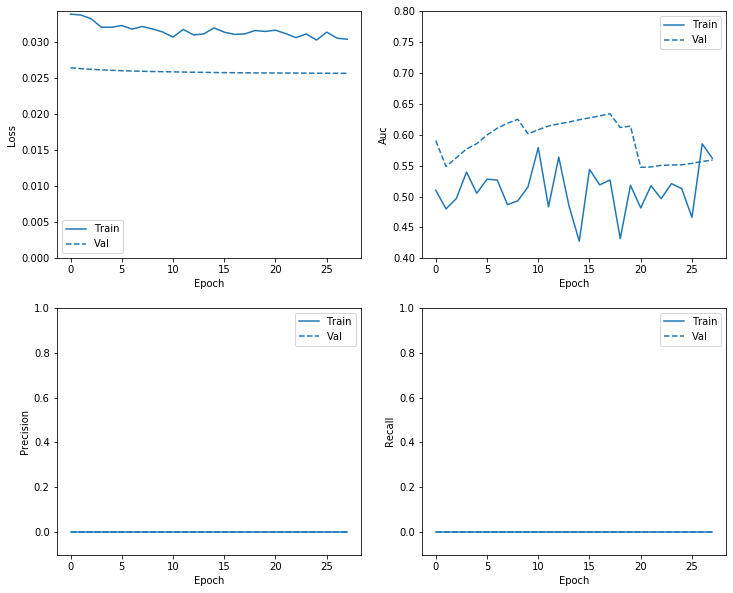

In [26]:
plot_metrics(baseline_history)

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Green Flags Predicted (True Negatives): ', cm[0][0])
    print('Yellow Flags Incorrectly Predicted (False Positives): ', cm[0][1])
    print('Yellow Flags Missed (False Negatives): ', cm[1][0])
    print('Yellow Flags Correctly Predicted (True Positives): ', cm[1][1])
    print('Total Yellow Flags: ', np.sum(cm[1]))

loss :  0.08736561983823776
tp :  0.0
fp :  0.0
tn :  3136.0
fn :  52.0
accuracy :  0.9836888313293457
precision :  0.0
recall :  0.0
auc :  0.41523683071136475

Green Flags Predicted (True Negatives):  3136
Yellow Flags Incorrectly Predicted (False Positives):  0
Yellow Flags Missed (False Negatives):  52
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  52


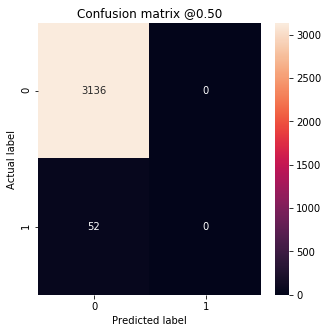

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

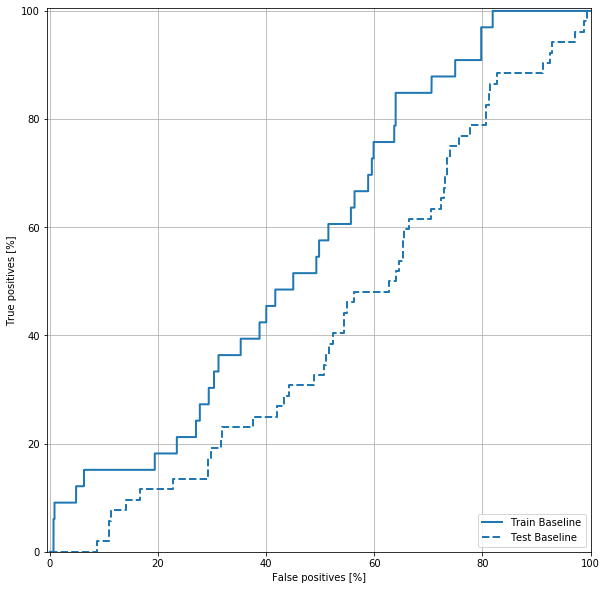

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

WEIGHTED

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 215.62


In [33]:
weighted_model = make_model(dropout=.5)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping


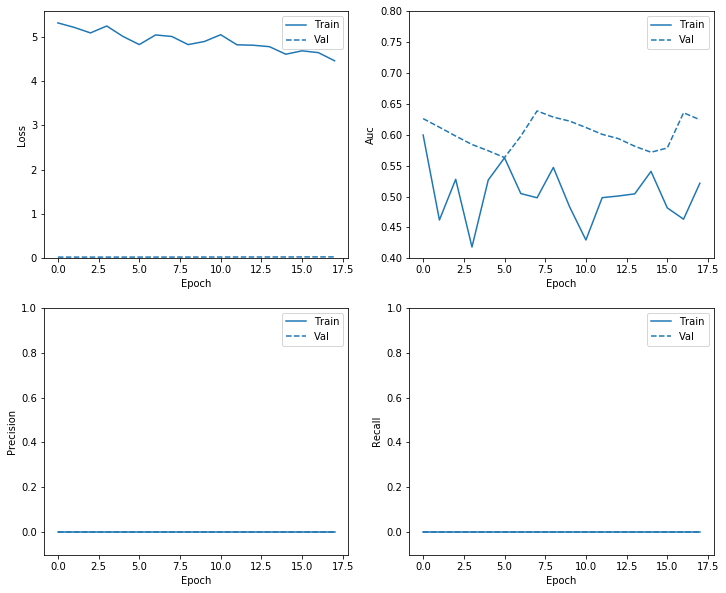

In [34]:
plot_metrics(weighted_history)

In [35]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.12933243811130524
tp :  0.0
fp :  0.0
tn :  3136.0
fn :  52.0
accuracy :  0.9836888313293457
precision :  0.0
recall :  0.0
auc :  0.4225342273712158

Green Flags Predicted (True Negatives):  3136
Yellow Flags Incorrectly Predicted (False Positives):  0
Yellow Flags Missed (False Negatives):  52
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  52


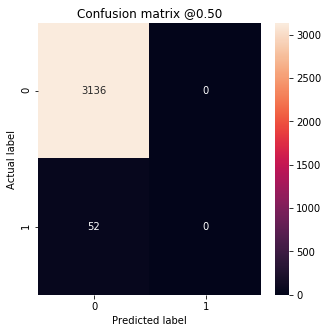

In [36]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

RESAMPLED

In [37]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [38]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [39]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [ 0.02957905 -0.18050069  0.45305904  0.03526606  0.77265234  1.1730382
  0.35961531]

Label:  1


In [40]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.37, 0.63])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [41]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.37451171875


In [42]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

9.0

In [71]:
resampled_model = make_model(dropout=0.435)
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds,
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping


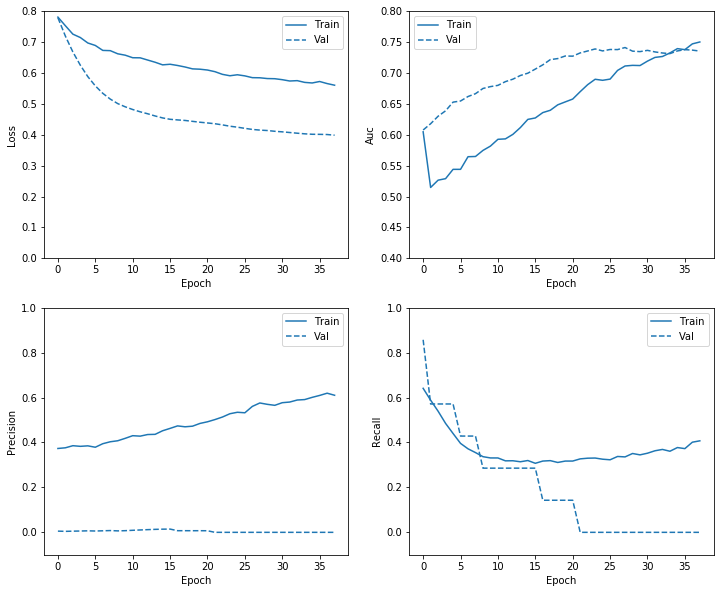

In [72]:
plot_metrics(resampled_history)

In [73]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.6096285581588745
tp :  23.0
fp :  1015.0
tn :  2121.0
fn :  29.0
accuracy :  0.6725219488143921
precision :  0.022157996892929077
recall :  0.4423076808452606
auc :  0.6099177002906799

Green Flags Predicted (True Negatives):  2121
Yellow Flags Incorrectly Predicted (False Positives):  1015
Yellow Flags Missed (False Negatives):  29
Yellow Flags Correctly Predicted (True Positives):  23
Total Yellow Flags:  52


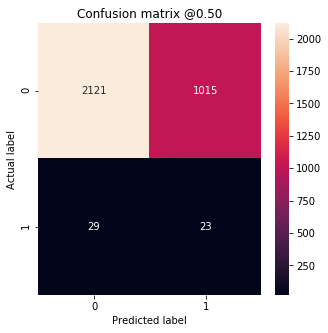

In [74]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

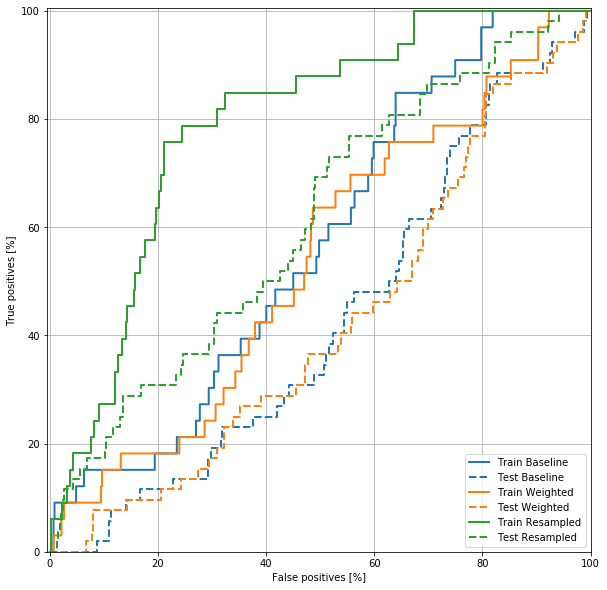

In [75]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

In [76]:
# for i in range(0, 3):
#     test_df = df_list[i]
#     test_df.pop('Time')
#     print(test_df.describe())
#     train_list = df_list[:i] + df_list[i+1:]
#     train_df = pd.concat(train_list)
    
#     train_df.pop('Time')

#     eps = 0.001 
#     train_df['Last Pit'] = np.log(train_df['Last Pit']+eps)
#     print(train_df.describe())
#     train_df, val_df = train_test_split(train_df, test_size=0.2)
